# Введение

В ноутбуке рассматривается классификация изображений на основе сходства векторных представлений. Используемый стек:

* **Pandas** для разведки данных и манипуляций с датасетом;
* **Matplotlib** для визуализации;
* **Scikit-Learn** для понижения размерности векторных представлений при визуализации;
* **OpenAI CLIP** - мультимодальная текстово-языковая модель для извлечения векторных представлений изображений;
* **PyTorch** для обучения и инференса нейронных сетей (в т. ч. CLIP);
* **PyTorch Metric Learning** для обучения модели классификации (сжатия) векторных представлений (возможно, не лучшая формулировка для metric learning);
* **FAISS** для поиска по индексу сжатых векторных представлений (из чего и строится классификация).

> Metric learning да, но зачем?

Ведь можно было бы просто взять любой предобученный классификатор, скажем, ResNet-34, до-обучить на текущем датасете и получить заветную Accuracy метрику (для данной задачи ее вполне достаточно, т. к. [спойлер] количество положительных и отрицательных примеров примерно одинаково [с небольшим перевесом у отрицательных]) 🤨

Можно, но:

1. Надо обучать глубокую модель (время + GPU) - в отличие от metric learning * подхода (да, можно заморозить нижние слои глубокой сети и до-обучать классификационные +/- несколько последних сверточных, но это все равно дольше + сложнее выявить проблему, если что-то пойдет "не так").
2. Результаты получаются менее интерпретируемыми - глубокая нейронная сеть как "черный ящик", ответ будет зависеть от того, какие визуальные признаки энкодер выучил как значимые **.

> * Для более обоснованных аргументов в пользу metric learning стоило бы сравнить (по метрикам) оба подхода - end-to-end классификатор на основе ResNet-34 и metric learning на основе CLIP (но время).

> ** В случае с end-to-end классификатором для интерпретации решения модели можно отрисовывать активации карт признаков.

# Зависимости

In [1]:
%%capture
%pip install pytorch-metric-learning
%pip install faiss-cpu
%pip install ftfy regex tqdm
%pip install git+https://github.com/openai/CLIP.git

# Анализ данных (EDA)

Датасет с картинками для классификации изображений Святого [Победоносца] Георгия (George / Not-George). В ноутбуке используется локальная копия, но на Kaggle есть [доступный всем датасет с Джорджем](https://www.kaggle.com/datasets/gobsan/st-george-or-not/code).

In [2]:
PATH_DATA = '/content/drive/MyDrive/george'

In [3]:
from os import listdir as ls


ls(PATH_DATA)

['george_test_task.zip',
 'georges.csv',
 'non_georges.csv',
 '.ipynb_checkpoints',
 'train_features.npy',
 'train_labels.npy',
 'test_features.npy',
 'test_labels.npy',
 'dataset_clip_test.pkl',
 'model_metric_script.pt',
 'george_positive.index',
 'george_negative.index',
 'main.py',
 '512px-Donatello,_san_giorgio_01.2.jpeg',
 '07CAT-STRIPES-mediumSquareAt3X-v2.jpg']

## Данные из интернета

CSV-таблицы с ссылками на данные.

### Джордж

In [4]:
from os import path as osp

import pandas as pd


frame_george_positive = pd.read_csv(osp.join(PATH_DATA, 'georges.csv'), header=None)

frame_george_positive[['url', 'file']] = frame_george_positive[0].str.rsplit('/', n=1, expand=True)

frame_george_positive

0  \
0     https://i.pinimg.com/736x/17/0d/5b/170d5b93d80...   
1     https://i.pinimg.com/736x/47/b9/9a/47b99a2ddcd...   
2     https://i.pinimg.com/736x/90/e8/90/90e890f054b...   
3     https://i.pinimg.com/736x/0a/71/6f/0a716f6f14e...   
4     https://i.pinimg.com/736x/f1/95/be/f195bea0b78...   
...                                                 ...   
2676  https://i.pinimg.com/736x/ec/55/2f/ec552fa0c0a...   
2677  https://i.pinimg.com/736x/a7/e2/e1/a7e2e10b8d6...   
2678  https://i.pinimg.com/736x/e0/d5/c5/e0d5c5eeac0...   
2679  https://i.pinimg.com/736x/77/4d/89/774d897ee7e...   
2680  https://i.pinimg.com/736x/95/5d/5e/955d5edfa0a...   

                                     url                                  file  
0     https://i.pinimg.com/736x/17/0d/5b  170d5b93d80d247be60f22ca1216bef7.jpg  
1     https://i.pinimg.com/736x/47/b9/9a  47b99a2ddcde2cf9e62b4faeec2fdf20.jpg  
2     https://i.pinimg.com/736x/90/e8/90  90e890f054b920308987c140125c9d19.jpg  
3     https://i.pinimg.com/736x/0a/71/6f  0a716f6f14eea3adc30e0944a7123759.jpg  
4     https://i.pinimg.com/736x/f1/95/be  f195bea0b78d1c0c90ab54341bf39536.jpg  
...                                  ...                                   ...  
2676  https://i.pinimg.com/736x/ec/55/2f  ec552fa0c0a050cbfdcd49be241e45da.jpg  
2677  https://i.pinimg.com/736x/a7/e2/e1  a7e2e10b8d6a332bd29ac52957f1b707.jpg  
2678  https://i.pinimg.com/736x/e0/d5/c5  e0d5c5eeac087aedf65a9e9063d25fb3.jpg  
2679  https://i.pinimg.com/736x/77/4d/89  774d897ee7eae0d557c161041eeee5d3.jpg  
2680  https://i.pinimg.com/736x/95/5d/5e  955d5edfa0a48b285329f8866407d5e7.jpg  

[2681 rows x 3 columns]

### Не-Джордж

In [5]:
frame_george_negative = pd.read_csv(osp.join(PATH_DATA, 'non_georges.csv'), header=None)

frame_george_negative[['url', 'file']] = frame_george_negative[0].str.rsplit('/', n=1, expand=True)

frame_george_negative

0  \
0     https://i.pinimg.com/736x/fd/65/bb/fd65bb679b7...   
1     https://i.pinimg.com/736x/78/63/a2/7863a2404af...   
2     https://i.pinimg.com/736x/bc/3a/f4/bc3af41444c...   
3     https://i.pinimg.com/736x/46/a3/59/46a3595eec7...   
4     https://i.pinimg.com/736x/54/b2/ef/54b2ef7af71...   
...                                                 ...   
3361  https://i.pinimg.com/736x/77/67/53/776753c14ee...   
3362  https://i.pinimg.com/736x/e5/d0/f4/e5d0f428313...   
3363  https://i.pinimg.com/736x/ba/d6/2b/bad62bc6efa...   
3364  https://i.pinimg.com/736x/e6/74/ad/e674adb02ce...   
3365  https://i.pinimg.com/736x/9c/04/71/9c04717e71b...   

                                     url                                  file  
0     https://i.pinimg.com/736x/fd/65/bb  fd65bb679b7975ab73867d62fba2e991.jpg  
1     https://i.pinimg.com/736x/78/63/a2  7863a2404af5741f6d9fdcb2e4ffad02.jpg  
2     https://i.pinimg.com/736x/bc/3a/f4  bc3af41444c7d8e4403691eb324941fb.jpg  
3     https://i.pinimg.com/736x/46/a3/59  46a3595eec7e6df1088b1b8139672423.jpg  
4     https://i.pinimg.com/736x/54/b2/ef  54b2ef7af71a9e522f6013b599eb31de.jpg  
...                                  ...                                   ...  
3361  https://i.pinimg.com/736x/77/67/53  776753c14eeb066cbb0e02114d40219a.jpg  
3362  https://i.pinimg.com/736x/e5/d0/f4  e5d0f428313ae6d8b98626dad1d9965e.jpg  
3363  https://i.pinimg.com/736x/ba/d6/2b  bad62bc6efa3883413df693fb6b48a87.jpg  
3364  https://i.pinimg.com/736x/e6/74/ad  e674adb02ce5765168f4e5da67608c5f.jpg  
3365  https://i.pinimg.com/736x/9c/04/71  9c04717e71b48ed92dcf2f456f1bc798.jpg  

[3366 rows x 3 columns]

## Данные в архиве

In [6]:
from pprint import pprint
from zipfile import ZipFile


with ZipFile(osp.join(PATH_DATA, 'george_test_task.zip')) as z:
    frame_george_test = pd.DataFrame(z.namelist())

frame_george_test

0
0                                     george_test_task/
1                              george_test_task/george/
2     george_test_task/george/47b99a2ddcde2cf9e62b4f...
3     george_test_task/george/0a716f6f14eea3adc30e09...
4     george_test_task/george/834404b9936f1424d4b2ae...
...                                                 ...
6047  george_test_task/no_george/d21df43de72af8c3fe3...
6048  george_test_task/no_george/008ee0b9f6bca98d16f...
6049  george_test_task/no_george/ed8ce704bd1bf9bdcb6...
6050  george_test_task/no_george/8bfa9f0cc20f613d3fd...
6051  george_test_task/no_george/7d01c74846cfabfb7b9...

[6052 rows x 1 columns]

In [7]:
frame_george_test[['root', 'class', 'file']] = frame_george_test[0].str.split('/', expand=True)

frame_george_test.replace('', None, inplace=True)
frame_george_test.dropna(inplace=True)

frame_george_test

0              root  \
2     george_test_task/george/47b99a2ddcde2cf9e62b4f...  george_test_task   
3     george_test_task/george/0a716f6f14eea3adc30e09...  george_test_task   
4     george_test_task/george/834404b9936f1424d4b2ae...  george_test_task   
5     george_test_task/george/f3dd3201859ff67b986c4f...  george_test_task   
6     george_test_task/george/24ff35f5c960bc12c21492...  george_test_task   
...                                                 ...               ...   
6047  george_test_task/no_george/d21df43de72af8c3fe3...  george_test_task   
6048  george_test_task/no_george/008ee0b9f6bca98d16f...  george_test_task   
6049  george_test_task/no_george/ed8ce704bd1bf9bdcb6...  george_test_task   
6050  george_test_task/no_george/8bfa9f0cc20f613d3fd...  george_test_task   
6051  george_test_task/no_george/7d01c74846cfabfb7b9...  george_test_task   

          class                                  file  
2        george  47b99a2ddcde2cf9e62b4faeec2fdf20.jpg  
3        george  0a716f6f14eea3adc30e0944a7123759.jpg  
4        george  834404b9936f1424d4b2ae392ec3834f.jpg  
5        george  f3dd3201859ff67b986c4fe681788db5.jpg  
6        george  24ff35f5c960bc12c21492a66552c6b7.jpg  
...         ...                                   ...  
6047  no_george  d21df43de72af8c3fe38488d4b66e6fe.jpg  
6048  no_george  008ee0b9f6bca98d16fe8108375e4d78.jpg  
6049  no_george  ed8ce704bd1bf9bdcb6333c6acf3dcd2.jpg  
6050  no_george  8bfa9f0cc20f613d3fd1bdf56b75ab20.jpg  
6051  no_george  7d01c74846cfabfb7b92edcb79e68398.jpg  

[6049 rows x 4 columns]

Количество файлов из non_georges.csv, non_georges.csv и архива соответственно:

In [8]:
len(frame_george_positive), len(frame_george_negative), len(frame_george_test)

(2681, 3366, 6049)

Количество файлов в CSV-таблицах:

In [9]:
2681 + 3366

6047

В архиве два лишних (6049 против 6047) 🤔 Это CSV-таблицы (помимо тех, что уже были выше).

А тут файлы, которые есть в архиве, но нет в CSV-таблицах:

In [10]:
frame_george_test[~frame_george_test['file'].isin(pd.concat([frame_george_positive['file'],
                                                            frame_george_negative['file']]))]

0              root  \
69    george_test_task/george/fe85f48b20b3bbedcad440...  george_test_task   
124   george_test_task/george/7e3096fa9a3ce2496aa046...  george_test_task   
125   george_test_task/george/297a1ed47f5b9fead14423...  george_test_task   
130   george_test_task/george/92dc13c8f08dee3504532a...  george_test_task   
131   george_test_task/george/922564445e332f5c43828c...  george_test_task   
...                                                 ...               ...   
5332  george_test_task/no_george/644b578a4fe52955eec...  george_test_task   
5352  george_test_task/no_george/bf9a390b3c8fddd422d...  george_test_task   
5456  george_test_task/no_george/61ab1a2740937a02f1a...  george_test_task   
5884  george_test_task/no_george/f25787a3dff82de9024...  george_test_task   
5919  george_test_task/no_george/6874d4e57bdc2f0e72f...  george_test_task   

          class                                    file  
69       george  fe85f48b20b3bbedcad440e835c64512.jpg.1  
124      george  7e3096fa9a3ce2496aa046bc7df61d50.jpg.1  
125      george  297a1ed47f5b9fead14423b561d382e1.jpg.1  
130      george  92dc13c8f08dee3504532a5e44257a2d.jpg.1  
131      george  922564445e332f5c43828c49cde3e7fb.jpg.1  
...         ...                                     ...  
5332  no_george  644b578a4fe52955eecd5b6c3d3e4687.jpg.1  
5352  no_george  bf9a390b3c8fddd422d47012f0b8cbff.jpg.1  
5456  no_george  61ab1a2740937a02f1a9a40e5e0474a9.jpg.1  
5884  no_george  f25787a3dff82de90246fff8a726f1ef.jpg.1  
5919  no_george  6874d4e57bdc2f0e72f465d02ee35109.jpg.1  

[349 rows x 4 columns]

Похоже, что дубликаты

In [11]:
ls()

['.config',
 '07CAT-STRIPES-mediumSquareAt3X-v2.jpg',
 'requirements.txt',
 'drive',
 '512px-Donatello,_san_giorgio_01.2.jpeg',
 'english-knight-lance-horse-england-flag-side-retro_mkNj3r_L.png',
 'george-sword.jpg',
 'george_test_task',
 'main.py',
 'sample_data']

In [12]:
%rm -rf george_test_task/

В принципе, уже пора бы и распаковать данные:

In [13]:
with ZipFile(osp.join(PATH_DATA, 'george_test_task.zip')) as z:
    z.extractall('.')
ls()

['.config',
 '07CAT-STRIPES-mediumSquareAt3X-v2.jpg',
 'requirements.txt',
 'drive',
 '512px-Donatello,_san_giorgio_01.2.jpeg',
 'english-knight-lance-horse-england-flag-side-retro_mkNj3r_L.png',
 'george-sword.jpg',
 'george_test_task',
 'main.py',
 'sample_data']

In [14]:
ls('george_test_task')

['george', 'no_george']

Количество файлов с точками и нормальных файлов:

In [15]:
from glob import glob
from os import rename as mv


filenames_mv = glob('george_test_task/*/*.jpg.*')
filenames = glob('george_test_task/*/*.jpg')

len(filenames_mv), len(filenames)

(347, 5700)

## Дубликаты

Как правило, дубликаты - это не очень хорошо. Мало того, что они сделают метрики завышенными из-за протечки обучающей подвыборки в тестовую (например, если используем случайное разбиение), внесут смещение в распределение визуальных признаков (модель может переобучиться под них), также (в данном случае) могут добавить ошибок чтения и распознавания форматов (если формат определяется по имени, а не по magic numbers).

Не очень хорошо, но их можно и проигнорировать, т. к. файлы с расширением `*.1` и `*.2` не входят в стандартный список `IMG_EXTENSIONS` файлов для класса `torchvision.datasets.DatasetFolder`

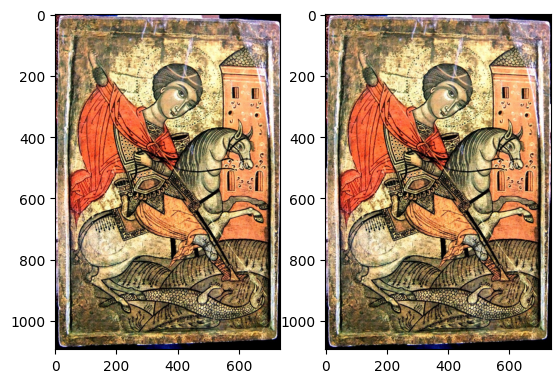

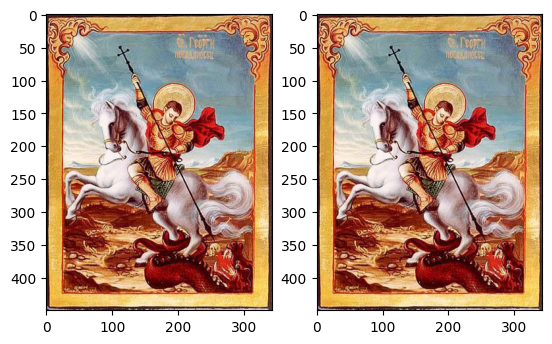

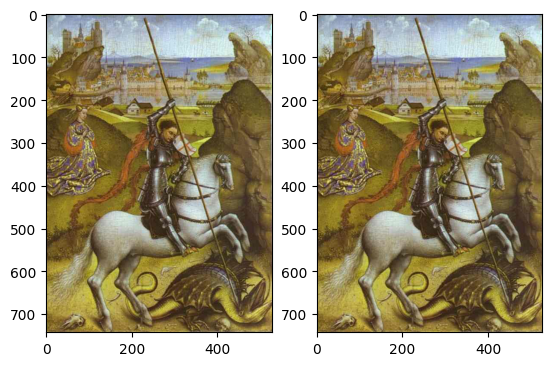

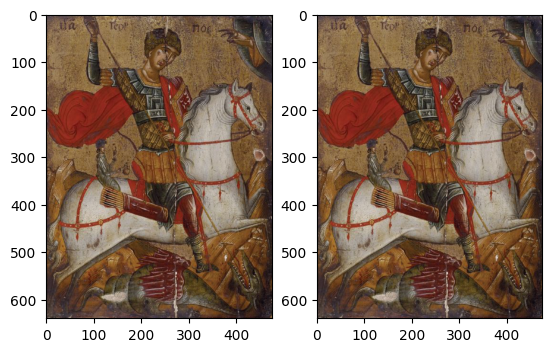

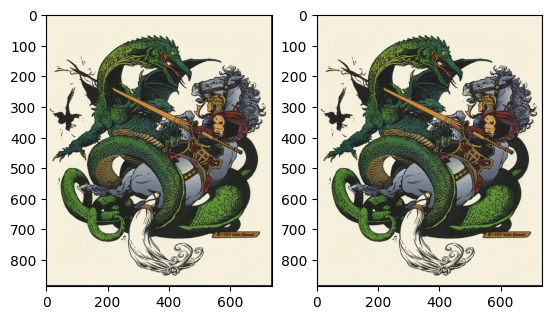

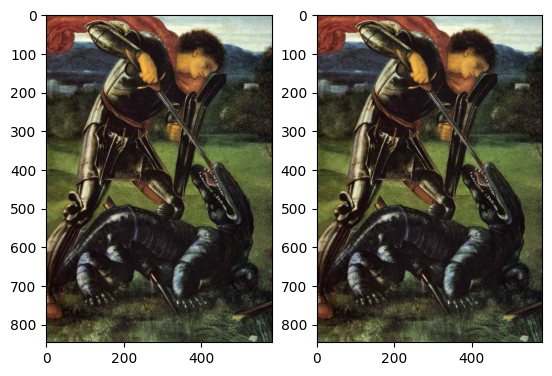

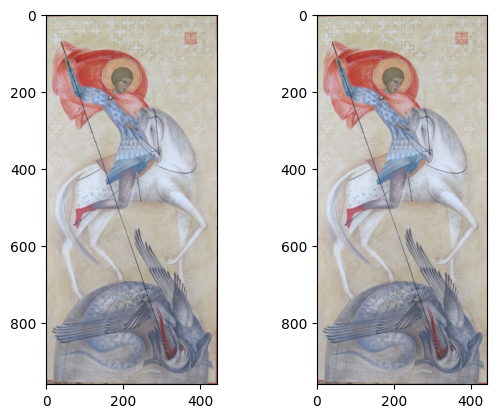

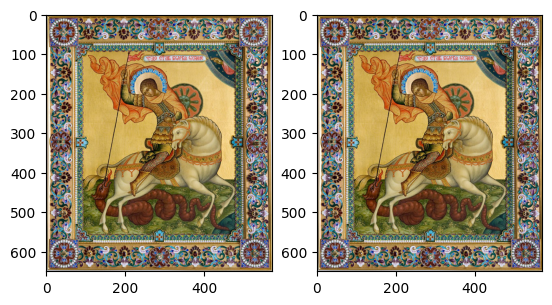

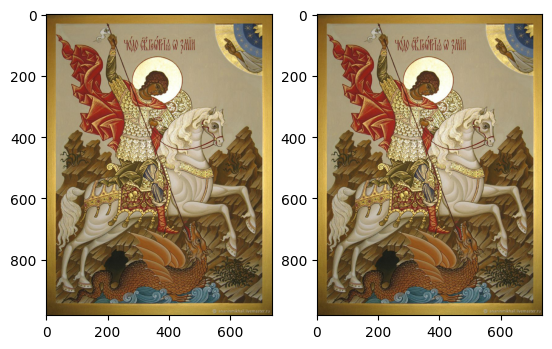

In [16]:
from re import sub as s

from matplotlib import pyplot as plt


count = 0
show = 8
for filename_mv in filenames_mv:
    try:
        assert osp.exists(filename_mv), f"File does not exist: {filename_mv}"
        name, ext = osp.splitext(filename_mv)
        if count <= show:
            figure, axes = plt.subplots(1, 2, figsize=(6.4, 4.8))
            axes[0].imshow(plt.imread(filename_mv))
            axes[1].imshow(plt.imread(name))
            plt.show()
        count += 1
    except Exception as ex:
        print(ex)

Итого нормальных файлов:

In [17]:
filenames = glob('george_test_task/*/*.jpg')

len(filenames)

5700

## Чистые данные (локально)

In [18]:
frame_george = pd.DataFrame(filenames)

frame_george[['root', 'class', 'file']] = frame_george[0].str.split('/', expand=True)

frame_george

0              root  \
0     george_test_task/george/22008faa3179f6f8a756ec...  george_test_task   
1     george_test_task/george/8fe4c5f733268e03e1afef...  george_test_task   
2     george_test_task/george/91bb8367e84080f254bede...  george_test_task   
3     george_test_task/george/5f441238c01bbbb1d2bcba...  george_test_task   
4     george_test_task/george/bdfd825c0a9d24af43b5f4...  george_test_task   
...                                                 ...               ...   
5695  george_test_task/no_george/4b89aea0f4ea6a1b174...  george_test_task   
5696  george_test_task/no_george/40adfcbe386d3273e02...  george_test_task   
5697  george_test_task/no_george/4a1524c117881376f49...  george_test_task   
5698  george_test_task/no_george/7292147ebeb6d4ba936...  george_test_task   
5699  george_test_task/no_george/198483298cb6f10adb8...  george_test_task   

          class                                  file  
0        george  22008faa3179f6f8a756ec186142e420.jpg  
1        george  8fe4c5f733268e03e1afefa41af3bed4.jpg  
2        george  91bb8367e84080f254bedecff0e3c8da.jpg  
3        george  5f441238c01bbbb1d2bcba3b61bac060.jpg  
4        george  bdfd825c0a9d24af43b5f49b3d27ca95.jpg  
...         ...                                   ...  
5695  no_george  4b89aea0f4ea6a1b174f997279796fc0.jpg  
5696  no_george  40adfcbe386d3273e022d87c1c399e78.jpg  
5697  no_george  4a1524c117881376f493e8530459f350.jpg  
5698  no_george  7292147ebeb6d4ba936d1b805b38ea13.jpg  
5699  no_george  198483298cb6f10adb884e6de461f797.jpg  

[5700 rows x 4 columns]

Предыдущий фрейм `frame_george_positive` не нужен (ибо с дубликатами он):

In [19]:
frame_george_positive = frame_george[frame_george['class'] == 'george']

frame_george_positive

0              root  \
0     george_test_task/george/22008faa3179f6f8a756ec...  george_test_task   
1     george_test_task/george/8fe4c5f733268e03e1afef...  george_test_task   
2     george_test_task/george/91bb8367e84080f254bede...  george_test_task   
3     george_test_task/george/5f441238c01bbbb1d2bcba...  george_test_task   
4     george_test_task/george/bdfd825c0a9d24af43b5f4...  george_test_task   
...                                                 ...               ...   
2355  george_test_task/george/721c85b74837afd266ef50...  george_test_task   
2356  george_test_task/george/1c71c371c152a3660cca65...  george_test_task   
2357  george_test_task/george/9e4c0c5c8a741026ec2cf4...  george_test_task   
2358  george_test_task/george/ffdfd511b4f8e8eb74f79a...  george_test_task   
2359  george_test_task/george/6d83854442b2bcedfec919...  george_test_task   

       class                                  file  
0     george  22008faa3179f6f8a756ec186142e420.jpg  
1     george  8fe4c5f733268e03e1afefa41af3bed4.jpg  
2     george  91bb8367e84080f254bedecff0e3c8da.jpg  
3     george  5f441238c01bbbb1d2bcba3b61bac060.jpg  
4     george  bdfd825c0a9d24af43b5f49b3d27ca95.jpg  
...      ...                                   ...  
2355  george  721c85b74837afd266ef50539aafd1b2.jpg  
2356  george  1c71c371c152a3660cca6577372ebabc.jpg  
2357  george  9e4c0c5c8a741026ec2cf4977e33bc31.jpg  
2358  george  ffdfd511b4f8e8eb74f79a8da1e1c2f2.jpg  
2359  george  6d83854442b2bcedfec919845b7820fe.jpg  

[2360 rows x 4 columns]

Фрейм с не-Джорджами тоже **не нужен**:

In [20]:
frame_george_negative = frame_george[frame_george['class'] == 'no_george']

frame_george_negative

0              root  \
2360  george_test_task/no_george/37f7d65d05af14f0255...  george_test_task   
2361  george_test_task/no_george/d7ca7a50bd216cbd094...  george_test_task   
2362  george_test_task/no_george/12012d068240f59ed72...  george_test_task   
2363  george_test_task/no_george/7cbe9a00dea7287257d...  george_test_task   
2364  george_test_task/no_george/d7218ab5fa764822ea9...  george_test_task   
...                                                 ...               ...   
5695  george_test_task/no_george/4b89aea0f4ea6a1b174...  george_test_task   
5696  george_test_task/no_george/40adfcbe386d3273e02...  george_test_task   
5697  george_test_task/no_george/4a1524c117881376f49...  george_test_task   
5698  george_test_task/no_george/7292147ebeb6d4ba936...  george_test_task   
5699  george_test_task/no_george/198483298cb6f10adb8...  george_test_task   

          class                                  file  
2360  no_george  37f7d65d05af14f0255a9717ab174971.jpg  
2361  no_george  d7ca7a50bd216cbd094cdf674c480627.jpg  
2362  no_george  12012d068240f59ed7252c36a89b3777.jpg  
2363  no_george  7cbe9a00dea7287257df13773df00731.jpg  
2364  no_george  d7218ab5fa764822ea90c4b9ea97df1a.jpg  
...         ...                                   ...  
5695  no_george  4b89aea0f4ea6a1b174f997279796fc0.jpg  
5696  no_george  40adfcbe386d3273e022d87c1c399e78.jpg  
5697  no_george  4a1524c117881376f493e8530459f350.jpg  
5698  no_george  7292147ebeb6d4ba936d1b805b38ea13.jpg  
5699  no_george  198483298cb6f10adb884e6de461f797.jpg  

[3340 rows x 4 columns]

## Отрисовка

По дубликатам понятно, теперь хочется посмотреть на тематическую составляющую исходных изображений.

Из очищенных фреймов можно просэмплировать (несколько раз) 16 штук изображений и понять, что там:

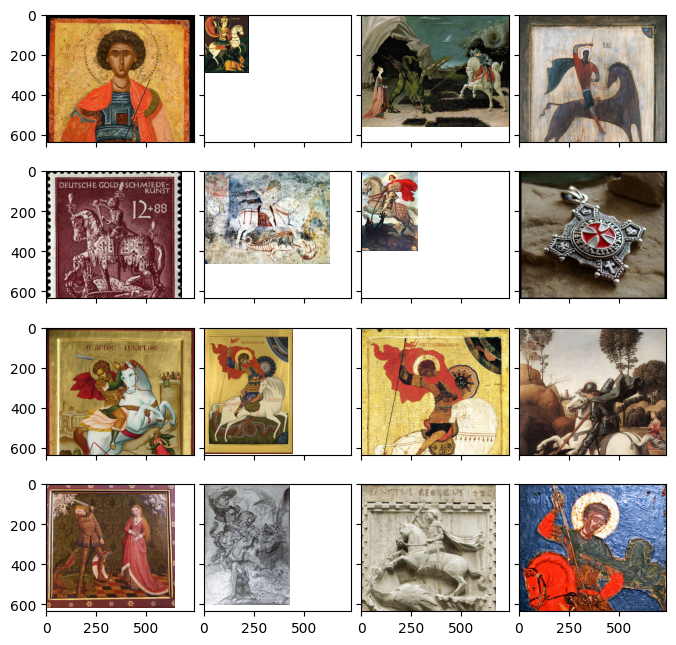

In [21]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid


SIZE_GRID = 4

figure = plt.figure(figsize=(SIZE_GRID * 2, SIZE_GRID * 2))
grid = ImageGrid(figure, 111, nrows_ncols=(SIZE_GRID, SIZE_GRID), axes_pad=0.1,
                 share_all=True, aspect=False)

for axis, filename in zip(grid, frame_george_positive[0].sample(SIZE_GRID * SIZE_GRID)):
    axis.imshow(plt.imread(filename))

А так же, что представляют собой не-Джорджи:

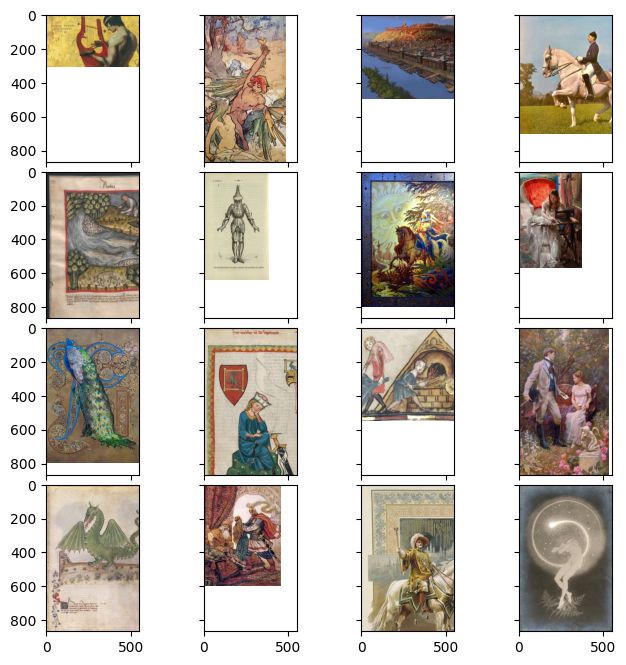

In [23]:
figure = plt.figure(figsize=(SIZE_GRID * 2, SIZE_GRID * 2))
grid = ImageGrid(figure, 111, nrows_ncols=(SIZE_GRID, SIZE_GRID), axes_pad=0.1,
                 share_all=True, aspect=False)

for axis, filename in zip(grid, frame_george_negative[0].sample(SIZE_GRID * SIZE_GRID)):
    axis.imshow(plt.imread(filename))

## Вывод

Итого имеем: изображения со Святым Георгием разного происхождения - от иконописи и символических изображений до современных артов и фотографий реальных скульптур в цвете. Т. о. изображения происходят из разных доменов.

Изображения с не-Георгием очень хорошо подобраны - в них есть те же атрибуты, что и у изображений с Георгием, поэтому классификатору не удастся переобучиться на стиль живописи/иконописи, либо всадников/копий/щитов.

# Векторные представления модели CLIP

> Свят Георгий во бое
>
> На лихом сидит коне,
>
> Держит в руце копие,
>
> Тычет змия...

Это не шутка! Все изображения с Георгием соответствуют описанию. Т. е. характерные атрибуты: святость, конь (в большинстве случав, хотя и не всегда), копье (иногда меч почему-то), а также змий - диавол и Сатана (всегда) и бой (кроме икон, где просто лицо и имя, но есть нимб).

Т. е. если изображение можно описать словами, среди которых будут перечислены все эти атрибуты, то с очень большой вероятностью на нем изображен Георгий Победоносец.

Описание изображения - это задача image captioning, которая решается текстово-картиночнвми мультимодальными моделями, коей является [OpenAI CLIP](https://openai.com/research/clip).


CLIP сопоставляет изображение текстовому описанию, поэтому векторные представления изображений должны довольно хорошо (кодировать) описывать (значимые) визуальные признаки для большого количества изображений из разных доменов.

Имея векторные представления (эмбеддинги) CLIP-а, можно обучить классификатор (2-3 полносвязных слоя нейронной сети). И это будет проще и эффективнее, чем обучать классификатор "с нуля" (ну почти, даже если это будут предобученные веса с ImageNet, т. к. потребуется больше времени).

In [25]:
import numpy as np
import torch


SEED = 74129

PATH_DATASET_CLIP_TEST = osp.join(PATH_DATA, 'dataset_clip_test.pkl')
PATH_MODEL_METRIC = osp.join(PATH_DATA, 'model_metric_script.pt')
PATH_INDEX_POSITIVE = osp.join(PATH_DATA, 'george_positive.index')
PATH_INDEX_NEGATIVE = osp.join(PATH_DATA, 'george_negative.index')

PATH_FEATURES_TRAIN = osp.join(PATH_DATA, 'train_features.npy')
PATH_LABELS_TRAIN = osp.join(PATH_DATA, 'train_labels.npy')
PATH_FEATURES_TEST = osp.join(PATH_DATA, 'test_features.npy')
PATH_LABELS_TEST = osp.join(PATH_DATA, 'test_labels.npy')

batch_size = 64

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

np.random.seed(SEED)

## Извлечение эмбеддингов

In [26]:
import os
import pickle

import clip

from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import ImageFolder
from tqdm import tqdm


def get_features(dataset, model):
    global batch_size
    all_features = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=batch_size)):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    return torch.cat(all_features).cpu().numpy(), torch.cat(all_labels).cpu().numpy()


train_saved = osp.exists(PATH_FEATURES_TRAIN) and osp.exists(PATH_LABELS_TRAIN)
test_saved = osp.exists(PATH_FEATURES_TEST) and osp.exists(PATH_LABELS_TEST)

if not train_saved or not test_saved:
    # Load the model
    model_clip, preprocess = clip.load('ViT-B/32', device)

    # Load the dataset
    dataset_clip_all = ImageFolder('george_test_task', transform=preprocess)
    dataset_clip_train, dataset_clip_test = torch.utils.data.random_split(
        dataset_clip_all, (0.8, 0.2)
    )

    with open(PATH_DATASET_CLIP_TEST, 'wb') as pkl:
        pickle.dump(dataset_clip_test, pkl)
else:
    model_clip, preprocess = None, None
    dataset_clip_test = pickle.load(open(PATH_DATASET_CLIP_TEST, 'rb'))

if train_saved:
    # Load pre-computed features
    train_features, train_labels = (
        np.load(PATH_FEATURES_TRAIN, allow_pickle=False),
        np.load(PATH_LABELS_TRAIN, allow_pickle=False)
    )
else:
    # Calculate the image features
    train_features, train_labels = get_features(dataset_clip_train, model_clip)
    np.save(PATH_FEATURES_TRAIN, train_features, allow_pickle=False)
    np.save(PATH_LABELS_TRAIN, train_labels, allow_pickle=False)

if test_saved:
    # Load pre-computed features
    test_features, test_labels = (
        np.load(PATH_FEATURES_TEST, allow_pickle=False),
        np.load(PATH_LABELS_TEST, allow_pickle=False)
    )
else:
    # Calculate the image features
    test_features, test_labels = get_features(dataset_clip_test, model_clip)
    np.save(PATH_FEATURES_TEST, test_features, allow_pickle=False)
    np.save(PATH_LABELS_TEST, test_labels, allow_pickle=False)

Как выглядят эмбеддинги CLIP и метки классов для обучающей подвыборки:

In [27]:
train_features.shape, train_labels.shape

((4560, 512), (4560,))

In [28]:
np.unique(train_labels)

array([0, 1])

А так для тестовой подвыборки:

In [29]:
test_features.shape, test_labels.shape

((1140, 512), (1140,))

In [30]:
np.unique(test_labels)

array([0, 1])

Так же полезно знать, что за предобработка у CLIP:

In [31]:
preprocess

## Визуализация представлений (T-SNE)

Представления из обучающей и тестовой подвыборок нужно разделить по классам:

In [32]:
features_george_positive = np.concatenate((train_features[(1 - train_labels).astype(np.bool8)],
                                           test_features[(1 - test_labels).astype(np.bool8)]))
features_george_negative = np.concatenate((train_features[train_labels.astype(np.bool8)],
                                           test_features[test_labels.astype(np.bool8)]))

features_george_positive.shape, features_george_negative.shape

((2360, 512), (3340, 512))

Для визуализации 512-мерных векторов в 2-мерном пространстве используется метод понижения размерности, известный как T-SNE (T-distributed Stochastic Neighbor Embedding):

In [33]:
from sklearn.manifold import TSNE


tsne = TSNE(n_components=2, verbose=1, random_state=SEED)

p = tsne.fit_transform(features_george_positive)
n = tsne.fit_transform(features_george_negative)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2360 samples in 0.001s...
[t-SNE] Computed neighbors for 2360 samples in 0.365s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2360
[t-SNE] Computed conditional probabilities for sample 2000 / 2360
[t-SNE] Computed conditional probabilities for sample 2360 / 2360
[t-SNE] Mean sigma: 1.806229
[t-SNE] KL divergence after 250 iterations with early exaggeration: 75.674400
[t-SNE] KL divergence after 1000 iterations: 1.309029
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3340 samples in 0.001s...
[t-SNE] Computed neighbors for 3340 samples in 0.565s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3340
[t-SNE] Computed conditional probabilities for sample 2000 / 3340
[t-SNE] Computed conditional probabilities for sample 3000 / 3340
[t-SNE] Computed conditional probabilities for sample 3340 / 3340
[t-SNE] Mean sigma: 1.946835
[t-SNE] KL divergence after 250 iterations with early exaggeration

Непосредственно визуализация при помощи Matplotlib scatterplot:

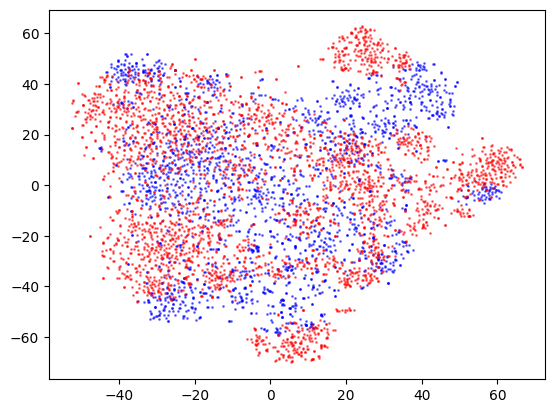

In [34]:
plt.scatter(p[:, 0], p[:, 1], c='blue', s=1, alpha=0.5)
plt.scatter(n[:, 0], n[:, 1], c='red', s=1, alpha=0.5)

Понижение размерности представлений дает приблизательную картину того, что в пространстве представлений изображения могут быть разделимы, хоть кое-где они и смешиваются.

Посмотрим, можно ли создать лучшее разделение при помощи metric learning.

# Metric Learning

## Векторные датасеты

In [35]:
dataset_features_train = TensorDataset(torch.tensor(train_features, device=device),
                                       torch.tensor(train_labels, device=device))
dataset_features_test = TensorDataset(torch.tensor(test_features, device=device),
                                      torch.tensor(test_labels, device=device))

loader_features_train = DataLoader(dataset_features_train, batch_size=batch_size,
                                   shuffle=True)
loader_features_test = DataLoader(dataset_features_test, batch_size=batch_size)

## Классификатор векторных представлений (модель)

Каждый CLIP-эмбеддинг - это одномерный вектор длины 512, поэтому первый слой классификатора также 512 каналов. Выходной слой в 2 раза меньше (попробуем metric learning).

Активация - новомодный Mish (это как ReLU, только дифференцируемый в нуле), про который [пишут](https://arxiv.org/pdf/1908.08681.pdf), что добавляет точности в задачи классификации.

In [36]:
def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch, progress=False):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()
        if progress and batch_idx % 20 == 0:
            print(
                f"Epoch {epoch} Iteration {batch_idx}: Loss = {loss}, "
                f"Number of mined triplets = {mining_func.num_triplets}"
            )
    print(
        f"Epoch {epoch} Iteration {batch_idx}: Loss = {loss}, "
        f"Number of mined triplets = {mining_func.num_triplets}"
    )


# Convenient function from pytorch-metric-learning
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)


# Compute accuracy using AccuracyCalculator from pytorch-metric-learning
def test(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    print('Computing accuracy...')
    accuracies = accuracy_calculator.get_accuracy(
        test_embeddings, test_labels, train_embeddings, train_labels, False
    )
    print(f"Test set accuracy (Precision@1) = {accuracies['precision_at_1']}")
    print()

In [37]:
from torch import nn


class NetCLIP(nn.Module):
    def __init__(self):
        super(NetCLIP, self).__init__()
        self.fc1 = nn.Linear(512, 512)
        self.ac1 = nn.Mish()
        self.fc2 = nn.Linear(512, 256)
        self.ac2 = nn.Mish()
        self.fc3 = nn.Linear(256, 128)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        x = self.ac2(x)
        x = self.fc3(x)
        return x

In [38]:
from torch import optim

from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator


model_x = NetCLIP().to(device)
optimizer = optim.Adam(model_x.parameters(), lr=0.01)
num_epochs = 100


### pytorch-metric-learning stuff ###
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=0)
loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
mining_func = miners.TripletMarginMiner(
    margin=0.2, distance=distance, type_of_triplets="semihard"
)
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1)
### pytorch-metric-learning stuff ###


if osp.exists(PATH_MODEL_METRIC):
    # Load pretrained model
    model_x = torch.jit.load(PATH_MODEL_METRIC)
    # Set model to 'eval' mode
else:
    # Train from scratch
    for epoch in range(1, num_epochs + 1):
        train(model_x, loss_func, mining_func, device, loader_features_train, optimizer, epoch)
        test(dataset_features_train, dataset_features_test, model_x, accuracy_calculator)
    # Save model
    model_scripted = torch.jit.script(model_x)
    model_scripted.save(PATH_MODEL_METRIC)
    # Set model to 'eval' mode

In [39]:
pml_features_train = []
pml_labels_train = []

with torch.no_grad():
    model_x.eval()
    for feature, label in loader_features_train:
        prediction = model_x(feature)
        pml_features_train.append(prediction)
        pml_labels_train.append(label)

pml_features_train = torch.concat(pml_features_train).numpy()
pml_labels_train = torch.concat(pml_labels_train).numpy()

pml_features_train.shape, pml_labels_train.shape

((4560, 128), (4560,))

In [40]:
pml_features_test = []
pml_labels_test = []

with torch.no_grad():
    model_x.eval()
    for feature, label in loader_features_test:
        prediction = model_x(feature)
        pml_features_test.append(prediction)
        pml_labels_test.append(label)

pml_features_test = torch.concat(pml_features_test).numpy()
pml_labels_test = torch.concat(pml_labels_test).numpy()

pml_features_test.shape, pml_labels_test.shape

((1140, 128), (1140,))

In [41]:
pml_features_positive = np.concatenate((pml_features_train[(1 - pml_labels_train).astype(np.bool8)],
                                           pml_features_test[(1 - pml_labels_test).astype(np.bool8)]))
pml_features_negative = np.concatenate((pml_features_train[pml_labels_train.astype(np.bool8)],
                                           pml_features_test[pml_labels_test.astype(np.bool8)]))

In [42]:
pml_features_positive.shape, pml_features_negative.shape

((2360, 128), (3340, 128))

In [43]:
pml_tsne = TSNE(n_components=2, verbose=1, random_state=SEED)

pml_p = tsne.fit_transform(pml_features_positive)
pml_n = tsne.fit_transform(pml_features_negative)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2360 samples in 0.001s...
[t-SNE] Computed neighbors for 2360 samples in 0.256s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2360
[t-SNE] Computed conditional probabilities for sample 2000 / 2360
[t-SNE] Computed conditional probabilities for sample 2360 / 2360
[t-SNE] Mean sigma: 6686.053087
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.764046
[t-SNE] KL divergence after 1000 iterations: 0.776587
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3340 samples in 0.001s...
[t-SNE] Computed neighbors for 3340 samples in 0.247s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3340
[t-SNE] Computed conditional probabilities for sample 2000 / 3340
[t-SNE] Computed conditional probabilities for sample 3000 / 3340
[t-SNE] Computed conditional probabilities for sample 3340 / 3340
[t-SNE] Mean sigma: 7624.446349
[t-SNE] KL divergence after 250 iterations with early exagge

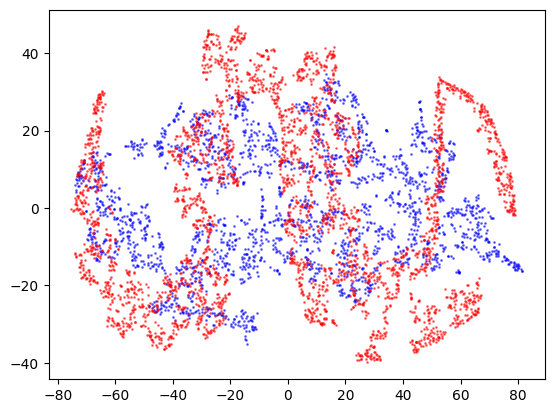

In [44]:
plt.scatter(pml_p[:, 0], pml_p[:, 1], c='blue', s=1, alpha=0.5)
plt.scatter(pml_n[:, 0], pml_n[:, 1], c='red', s=1, alpha=0.5)

## Поиск по ближайшим соседям

In [45]:
pml_features_positive.max()

75031.73

In [46]:
pml_features_negative.max()

146875.19

## Создание индексов

In [47]:
import faiss


pml_positive_train, pml_positive_test = (
    pml_features_train[(1 - pml_labels_train).astype(np.bool8)],
    pml_features_test[(1 - pml_labels_test).astype(np.bool8)]
)

pml_negative_train, pml_negative_test = (
    pml_features_train[pml_labels_train.astype(np.bool8)],
    pml_features_test[pml_labels_test.astype(np.bool8)]
)

d = pml_positive_train.shape[-1]  # d-dimentional vectors

Непосредственно сами индексы:

In [48]:
index_positive_train = faiss.IndexFlatIP(d)
index_negative_train = faiss.IndexFlatIP(d)

index_positive_train.add(pml_positive_train)
index_negative_train.add(pml_negative_train)

In [49]:
index_positive_train.is_trained, index_positive_train.ntotal

(True, 1877)

In [50]:
index_negative_train.is_trained, index_negative_train.ntotal

(True, 2683)

### Дамп полных индексов (для инференса)

In [51]:
if not osp.exists(PATH_INDEX_POSITIVE):
    print(f"Writing index: {PATH_INDEX_POSITIVE}")
    index_positive_total = faiss.IndexFlatIP(d)
    index_positive_total.add(pml_positive_train)
    index_positive_total.add(pml_positive_test)
    faiss.write_index(index_positive_total, PATH_INDEX_POSITIVE)
else:
    print(f"Reading index: {PATH_INDEX_POSITIVE}")
    index_positive_total = faiss.read_index(PATH_INDEX_POSITIVE)

if not osp.exists(PATH_INDEX_NEGATIVE):
    print(f"Writing index: {PATH_INDEX_NEGATIVE}")
    index_negative_total = faiss.IndexFlatIP(d)
    index_negative_total.add(pml_negative_train)
    index_negative_total.add(pml_negative_test)
    faiss.write_index(index_negative_total, PATH_INDEX_NEGATIVE)
else:
    print(f"Reading index: {PATH_INDEX_NEGATIVE}")
    index_negative_total = faiss.read_index(PATH_INDEX_NEGATIVE)

Reading index: /content/drive/MyDrive/george/george_positive.index
Reading index: /content/drive/MyDrive/george/george_negative.index


Результат поиска по индексу векторов - это пара дистанции-индексы. Индексы из "обучающей" подвыборки (набора векторов, на которых строился FAISS-индекс).

> Небольшая путаница с терминологией: "индекс" как исходный набор для поиска ближайших соседей (структура FAISS) и "индексы" у каждого вектора в структуре-"индексе".

In [52]:
distance_p_p, index_p_p = index_positive_train.search(pml_positive_test, 1)
distance_p_n, index_p_n = index_negative_train.search(pml_positive_test, 1)

In [53]:
distance_p_p.shape, index_p_p.shape, distance_p_n.shape, index_p_n.shape

((483, 1), (483, 1), (483, 1), (483, 1))

In [54]:
distance_n_p, index_n_p = index_positive_train.search(pml_negative_test, 1)
distance_n_n, index_n_n = index_negative_train.search(pml_negative_test, 1)

In [55]:
distance_n_p.shape, index_n_p.shape, distance_n_n.shape, index_n_n.shape

((657, 1), (657, 1), (657, 1), (657, 1))

Вообще значения в возвращаемых индексах не обязаны быть уникальными, и, зачастую, там много повторяющихся.

Правильно угаданные положитальные примеры (тестовые) - это те, для которых при сравнении с положительным индексом метрика больше, чем при сравнении с отрицательным.

> Снова может возникнуть путаница: называется переменная `distance_*`, а правильными выбираются те, у которых это "расстояние" больше (хотя по логике - чем больше расстояние, тем примеры дальше, тем хуже). Для `IndexFlatIP` (Inner Product) метрика - близость (а для нормализованных векторов это косинусная близость), т. е. чем больше, тем лучше.

In [56]:
result_true_positive = distance_p_p > distance_p_n

Аналогично с отрицательными примерами (тестовыми).

In [57]:
result_true_negative = distance_n_n > distance_n_p

In [58]:
result_true_positive.shape, result_true_negative.shape

((483, 1), (657, 1))

Имея правильно ~~угаданные~~ рассчитанные (true) и неправильно (false) для положительных и отрицательных примеров Джорджей, можно посчитать True Positive, False Positive, True Negative, False Negative и перейти к привычным метрикам типа Accuracy.

> В отличие от классификационной модели, результат получается более интерпретируемым (потому что примеры не угадываются, а считаются, метрику можно выбирать без переобучения модели).

In [59]:
tp = result_true_positive.sum()
fp = result_true_positive.shape[0] - tp

tp, fp

(459, 24)

In [60]:
tn = result_true_negative.sum()
fn = result_true_negative.shape[0] - tn

tn, fn

(628, 29)

График с комбинациями значений метрик близости для положительных и отрицательных примеров:

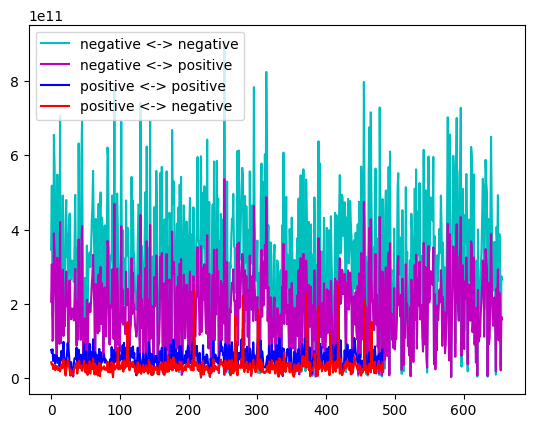

In [61]:
plt.plot(distance_n_n, c='c')
plt.plot(distance_n_p, c='m')
plt.plot(distance_p_p, c='b')
plt.plot(distance_p_n, c='r')
plt.legend(['negative <-> negative', 'negative <-> positive',
            'positive <-> positive', 'positive <-> negative'])
plt.show()

Точность, какую бы измеряли в задаче классификации:

In [62]:
print(f"Accuracy = {(tp + tn) / (tp + tn + fp + fn)}")

Accuracy = 0.9535087719298245


## Визуализация лжесрабатываний

Что же это за изображения такие, что попдают не в свой кластер?

Получение тестовой подвыборки с сохранением порядка элементов:

In [63]:
frame_data_test = pd.DataFrame(dataset_clip_test.dataset.imgs, columns=['file', 'class'])

frame_data_test = frame_data_test.iloc[dataset_clip_test.indices]

frame_data_test

file  class
5542  george_test_task/no_george/f4de00db5e2f3ab95f2...      1
1709  george_test_task/george/b6ebe0ba2e08dd665c7798...      0
1409  george_test_task/george/95ee1fffb768957d2abf71...      0
863   george_test_task/george/5cb12c46771f59fc5b16cd...      0
3412  george_test_task/no_george/50dcc85cd8571a6afd8...      1
...                                                 ...    ...
1157  george_test_task/george/7b78e2d3b8e270383922f1...      0
1221  george_test_task/george/824695ccb03d40ce911f2b...      0
2324  george_test_task/george/fcb8d73d7f4aa124b70750...      0
2803  george_test_task/no_george/21d872da5580d702a92...      1
2995  george_test_task/no_george/318b7dc79bc525e61d9...      1

[1140 rows x 2 columns]

Положительные примеры, соответствующие положительной тестовой подвыборке:

In [64]:
frame_data_test_positive = frame_data_test[frame_data_test['class'] == 0]

frame_data_test_positive

file  class
1709  george_test_task/george/b6ebe0ba2e08dd665c7798...      0
1409  george_test_task/george/95ee1fffb768957d2abf71...      0
863   george_test_task/george/5cb12c46771f59fc5b16cd...      0
2055  george_test_task/george/df277f115f8306d65ca301...      0
277   george_test_task/george/1d28e9abc6f6e3d733abe8...      0
...                                                 ...    ...
537   george_test_task/george/39411775cd4347ebe094d9...      0
142   george_test_task/george/0f7817e267f4e8afb8b08d...      0
1157  george_test_task/george/7b78e2d3b8e270383922f1...      0
1221  george_test_task/george/824695ccb03d40ce911f2b...      0
2324  george_test_task/george/fcb8d73d7f4aa124b70750...      0

[483 rows x 2 columns]

Отрицательные примеры, соответствующие отрицательной тестовой подвыборке:

In [65]:
frame_data_test_negative = frame_data_test[frame_data_test['class'] == 1]

frame_data_test_negative

file  class
5542  george_test_task/no_george/f4de00db5e2f3ab95f2...      1
3412  george_test_task/no_george/50dcc85cd8571a6afd8...      1
3339  george_test_task/no_george/4b89aea0f4ea6a1b174...      1
3470  george_test_task/no_george/55548b5b9ed867bd9c7...      1
2759  george_test_task/no_george/1ef6ede86dde9095bbe...      1
...                                                 ...    ...
4091  george_test_task/no_george/839f9243de08e6588dd...      1
4120  george_test_task/no_george/8650a2c2aa2aac0bf0a...      1
2441  george_test_task/no_george/064029ac4eec71aa9a8...      1
2803  george_test_task/no_george/21d872da5580d702a92...      1
2995  george_test_task/no_george/318b7dc79bc525e61d9...      1

[657 rows x 2 columns]

False Positive:

In [66]:
frame_data_test_positive_false = frame_data_test_positive[~result_true_positive]

frame_data_test_positive_false

file  class
2138  george_test_task/george/e8d90e16a20551ecddf4ea...      0
1834  george_test_task/george/c57a1b73c2ea352e2e460d...      0
813   george_test_task/george/56ae14479d6bf88b2302ce...      0
1731  george_test_task/george/b91407a00a521caf2e5dc5...      0
2288  george_test_task/george/f89e92663821462dc281c4...      0
514   george_test_task/george/36fce57c5487067855d6de...      0
1464  george_test_task/george/9c95c00c194337b59ac15e...      0
559   george_test_task/george/3bc263b94581dd01833aae...      0
1256  george_test_task/george/853f1b5daca0fb3c3de1ab...      0
1209  george_test_task/george/813cec74828eb4638996bb...      0
571   george_test_task/george/3d52bfeb626a0679588d36...      0
2174  george_test_task/george/ebcaf58b5d319bfceec55c...      0
925   george_test_task/george/633f1ecbbaa9112315fec0...      0
1960  george_test_task/george/d45ad4b9f3d01af4f7b631...      0
504   george_test_task/george/35c1fae8d598894d659c8a...      0
1128  george_test_task/george/78f9bebfb87e2e497285e8...      0
1282  george_test_task/george/8763dc390496130408da57...      0
1865  george_test_task/george/c99c68764a91659a66efef...      0
2199  george_test_task/george/ee1820de0b17400361b509...      0
499   george_test_task/george/34d4408f9e9050578e2a09...      0
1833  george_test_task/george/c56c15f9cfeee622e25b6d...      0
833   george_test_task/george/593e70b48ee3cbdbd5c7cf...      0
306   george_test_task/george/1fd26067c72e5c0f0e4c30...      0
888   george_test_task/george/5ed8853235c80ae6a66d7a...      0

False Negative:

In [67]:
frame_data_test_negative_false = frame_data_test_negative[~result_true_negative]

frame_data_test_negative_false

file  class
2943  george_test_task/no_george/2dc74694093f2d06c6a...      1
3701  george_test_task/no_george/661fd282c52912e6df1...      1
3287  george_test_task/no_george/47cce60b16490359b70...      1
5031  george_test_task/no_george/cf080aad71c0cf3a5e6...      1
4764  george_test_task/no_george/ba10ade76b96e613cb8...      1
2570  george_test_task/no_george/110d5d936b2e585026c...      1
5090  george_test_task/no_george/d2070a386afa100e348...      1
3327  george_test_task/no_george/4af5ceb02c6a1c81b62...      1
5292  george_test_task/no_george/e2c9142403959291dc9...      1
3045  george_test_task/no_george/357a382d7e37cdd51f2...      1
4753  george_test_task/no_george/b8c3349e338ad10d8f2...      1
4510  george_test_task/no_george/a5221094d93964b9991...      1
3160  george_test_task/no_george/3e47b311ebf96722730...      1
4877  george_test_task/no_george/c217b129a3f688780d6...      1
5649  george_test_task/no_george/fc642ff995cf6c6bc4e...      1
2714  george_test_task/no_george/1bb38303612ff9594e2...      1
3191  george_test_task/no_george/40b73205da49e05b747...      1
5589  george_test_task/no_george/f7fe9b34d868a2332fb...      1
5169  george_test_task/no_george/d8fd35f1ea2381e4668...      1
2427  george_test_task/no_george/056311f16ceb2ff472e...      1
4223  george_test_task/no_george/8e7cb41a5b5d7bb3868...      1
2583  george_test_task/no_george/11c46c946df400d2f47...      1
3718  george_test_task/no_george/67e1fed76e203a121bf...      1
4502  george_test_task/no_george/a45632d880e394cc285...      1
3018  george_test_task/no_george/3338089bf6119a2ac43...      1
4999  george_test_task/no_george/cc657e04b56e6848bbe...      1
2578  george_test_task/no_george/11aba7186bf34613520...      1
5450  george_test_task/no_george/edb9c8a9440fc8644f3...      1
5132  george_test_task/no_george/d5d6cb7c66201ae9e1a...      1

Всего элементов, попавших не в свой набор:

In [68]:
len(frame_data_test_positive_false), len(frame_data_test_positive_false)

(24, 24)

### Лжегеоргии

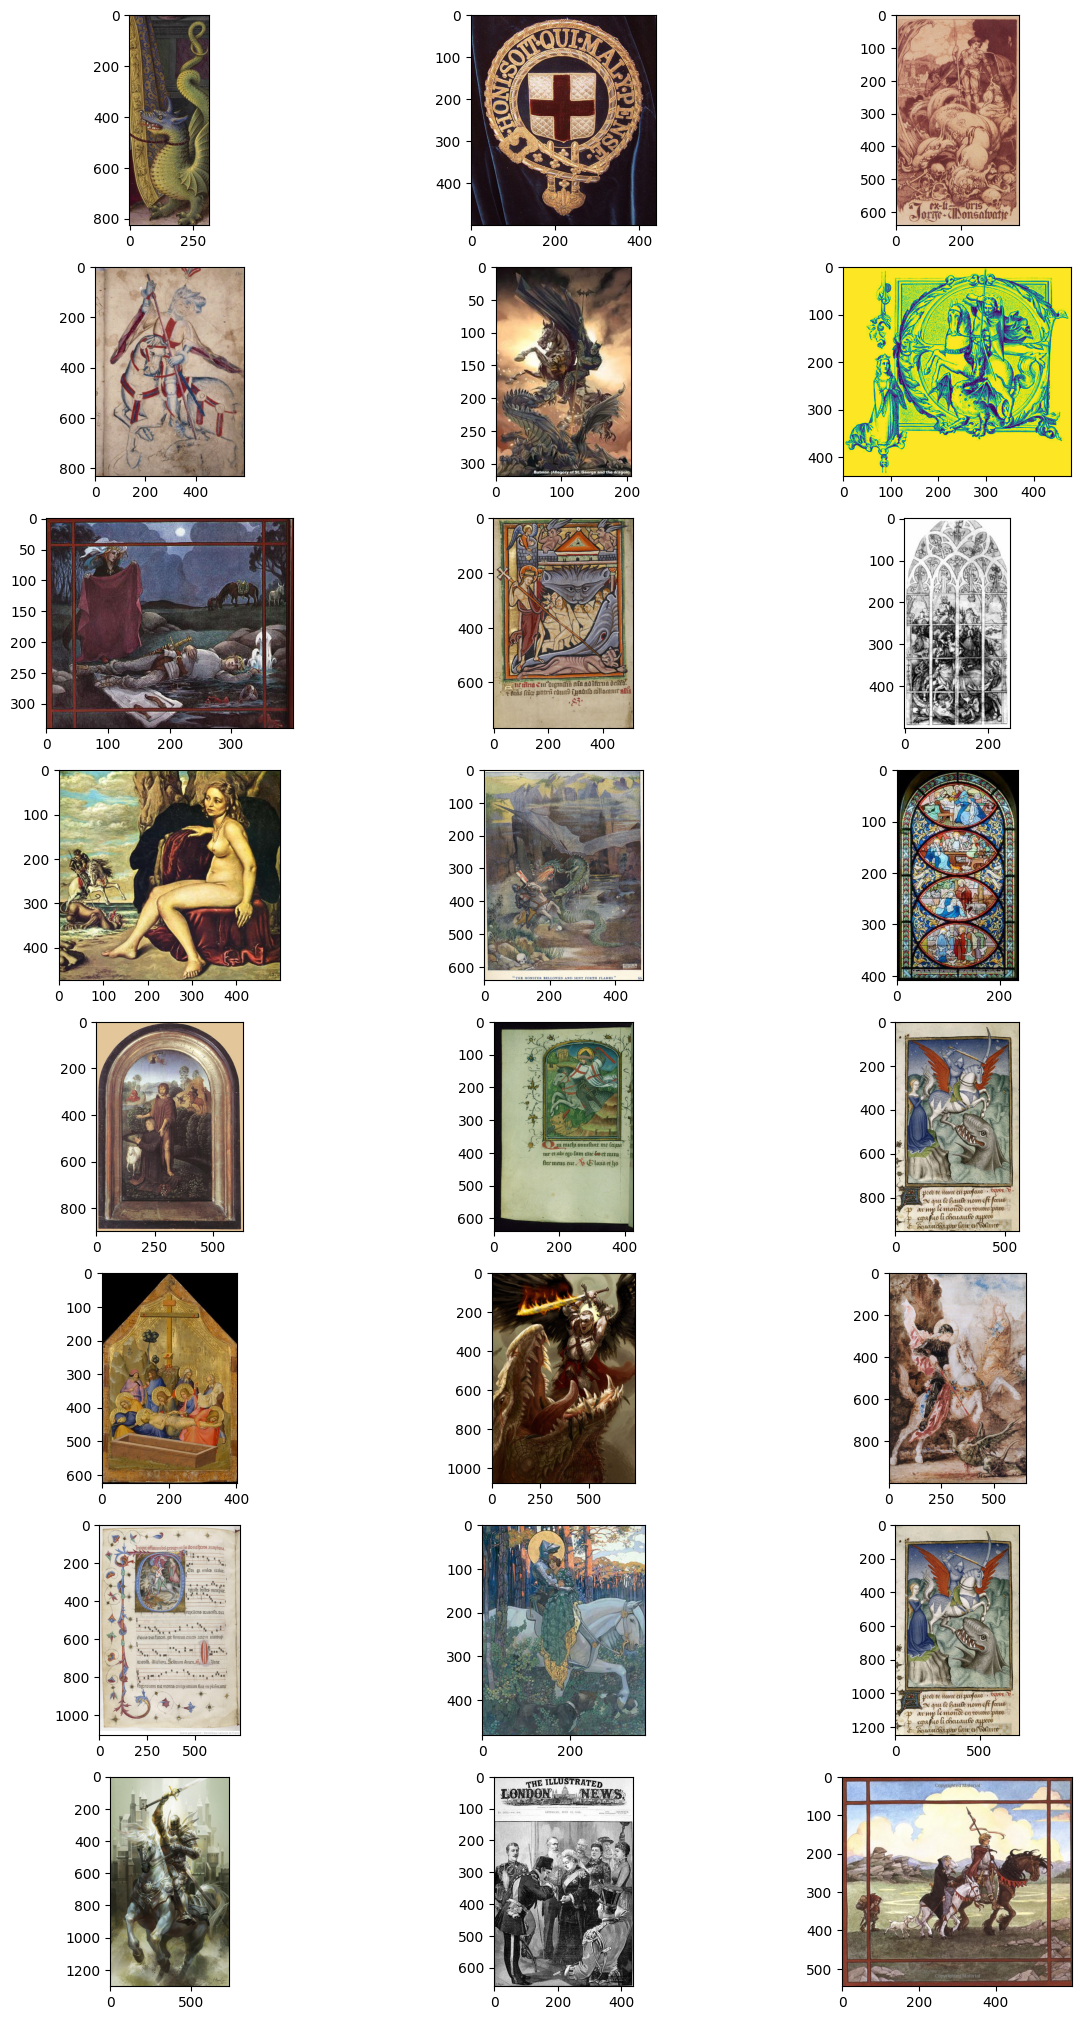

In [69]:
nrows, ncols = 8, 3

figure, axes = plt.subplots(nrows, ncols, figsize=(14.4, 25.6))
axes = axes.flatten()
for i, x in enumerate(frame_data_test_positive_false.iterrows()):
    if i >= nrows * ncols:
        break
    axes[i].imshow(plt.imread(x[-1]['file']))

По метрикам схожести эти картинки больше не-Георгии, чем Георгии.

### Лженегеоргии

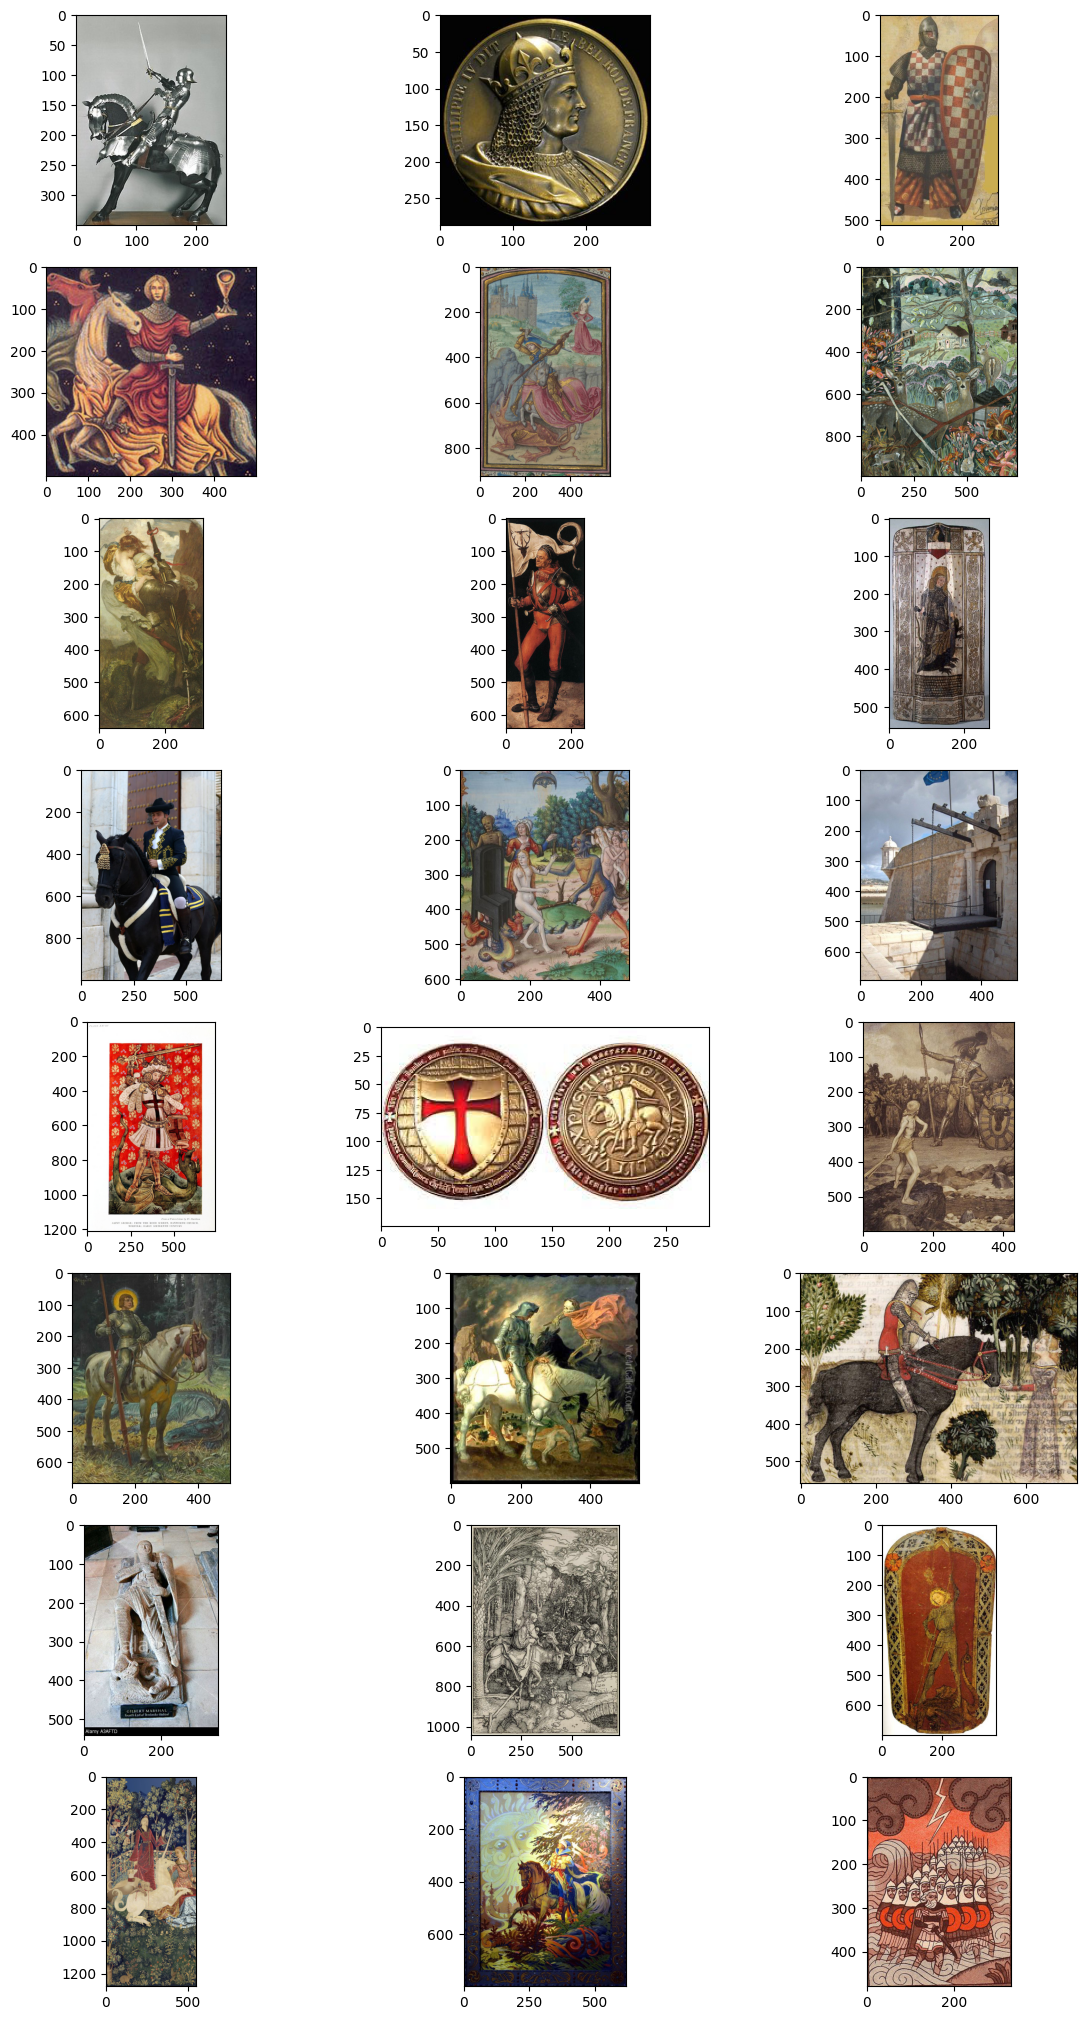

In [70]:
nrows, ncols = 8, 3

figure, axes = plt.subplots(nrows, ncols, figsize=(14.4, 25.6))
axes = axes.flatten()
for i, x in enumerate(frame_data_test_negative_false.iterrows()):
    if i >= nrows * ncols:
        break
    axes[i].imshow(plt.imread(x[-1]['file']))

В этих картинках наоборот - больше Георгиевских признаков.

# Инференс

In [71]:
PATH_DATA = '/content/drive/MyDrive/george'

In [72]:
%%writefile requirements.txt
pytorch-metric-learning
faiss-cpu
ftfy
regex
git+https://github.com/openai/CLIP.git

Overwriting requirements.txt


In [73]:
%%capture
%pip install -r requirements.txt

In [74]:
%%writefile main.py
import clip
import faiss
import torch

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor


class DatasetSingle(Dataset):
    def __init__(self, path_image, transform=None):
        self.path_image = path_image
        self.transform = transform
        self.max_size = 512

    def __getitem__(self, i):
        image = Image.open(self.path_image)
        label = torch.tensor([0])
        if self.transform:
            image = self.transform(image)
        else:
            image = ToTensor()(image)
        return image, label

    def __len__(self):
        return 1


def predict(path_model, path_index_positive, path_index_negative, path_images, verbose=False):
    if isinstance(path_images, (dict, list, tuple, set)):
        path_images = tuple(path_images)
    else:
        path_images = (path_images, )
    device = torch.device('cpu')

    model_clip, preprocess = clip.load('ViT-B/32', device)
    model_metric = torch.jit.load(path_model)

    index_positive_total = faiss.read_index(path_index_positive)
    index_negative_total = faiss.read_index(path_index_negative)

    with torch.no_grad():
        model_clip.eval()
        for path_image in path_images:
            for images, labels in DataLoader(DatasetSingle(path_image,
                                                           preprocess),
                                            batch_size=1):
                if (verbose):
                    print(f"Extracting CLIP embeddings...")
                features = model_clip.encode_image(images.to(device))
                if (verbose):
                    print(f"Compressing embeddings...")
                features_latent = model_metric(features)
                if (verbose):
                    print(f"Matching against positive index...")
                distance_p, index_p = index_positive_total.search(
                    features_latent, 1
                )
                if (verbose):
                    print(f"Matching against negative index...")
                distance_n, index_n = index_negative_total.search(
                    features_latent, 1
                )
                if (verbose):
                    print(f"Compare results:")
                result_true = distance_p > distance_n
                result = result_true.squeeze().item()
                print(f"'{path_image}' {['does NOT look', 'LOOKS'][result]} like St. George")
def main(args):
    predict(args.path_model, args.path_index_positive, args.path_index_negative,
            args.path_images, args.verbose)

if __name__ == '__main__':
    from argparse import ArgumentParser

    parser = ArgumentParser()
    parser.add_argument('-m', '--model', dest='path_model', required=True,
                        metavar='path', help='path to metric model')
    parser.add_argument('-p', '--positive', dest='path_index_positive',
                        required=True, metavar='path',
                        help='path to positive index')
    parser.add_argument('-n', '--negative', dest='path_index_negative',
                        required=True, metavar='path',
                        help='path to negative index')
    parser.add_argument('-v', '--verbose', action='store_true',
                        help='verbosely display progress')
    parser.add_argument('path_images', nargs=1, metavar='path',
                        help='path to the image of George/Not-George')
    main(parser.parse_args())

Overwriting main.py


## Предсказание

In [75]:
!python main.py -m {PATH_DATA}/model_metric_script.pt -p {PATH_DATA}/george_positive.index -n {PATH_DATA}/george_negative.index 512px-Donatello,_san_giorgio_01.2.jpeg

'512px-Donatello,_san_giorgio_01.2.jpeg' LOOKS like St. George


In [76]:
!python main.py -m {PATH_DATA}/model_metric_script.pt -p {PATH_DATA}/george_positive.index -n {PATH_DATA}/george_negative.index 07CAT-STRIPES-mediumSquareAt3X-v2.jpg

'07CAT-STRIPES-mediumSquareAt3X-v2.jpg' does NOT look like St. George


# Заключение

В итоге было что было сделано для решения задачи бинарной классификации Джордж/не-Джордж:
1. Исследован датасет, удалены дубликаты.
2. Использована мультимодальная текстово-картиночная модель CLIP для получения векторных представлений ихображений.
3. Обучен классификатор векторных представлений при помощи metric learning.
4. Проанализированы лжесрабатывания классификатора.
5. Подготовлен скрипт для инференса без использования ноутбука.

Что можно (хотелось) было бы сделать:
1. Обучить end-to-end классификатор и сравнить результаты (тогда можно было бы обоснованно утверждать, какой метод лучше).
2. Сравнить обучающую и тестовую подвыборки на основе векторных представлений CLIP (до классификатора), чтобы более обоснованно утверждать, что metric learning классификатор внес свой вклад.
3. Обучить metric learning классификатор для 2-мерного вектора (а не 128-мерного, как в текущем решении) - тогда не пришлось бы использовать T-SNE для понижения размерности при отрисовке.
4. Использовать другие метрики PML для сравнения.
5. Кластеризовать и использовать центры кластеров в индексах для сравнения, сравнить метрики для различного количества кластеров.